# Intent Recognition Using BERT


---


**Practice Module: Practical Language Processing (PLP)**

**Group: 17**

Members:

`Lim Jun Ming`, `A0231523U`

`Tadhg Kennedy`, 

`Gopan Ravikumar Girija`,

# 0. Initialization

In [1]:
# !pip install transformers

In [2]:
# !pip install torchinfo

## Imports

In [1]:
import os
# from google.colab import drive

import numpy as np
import pandas as pd
import json
import random
import time
import datetime
import pickle
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from transformers import BertTokenizerFast, BertModel

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler


## Mounting Drive

In [4]:
# # Mounting to Google Drive
# drive.mount('/content/gdrive')

# # Change Working Directory
# os.chdir('/content/gdrive/My Drive/iss/plp_pm/')

## Pytorch Setups

In [2]:
# Print Torch version
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print('-' * 10)

# Check GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1.10.1+cu113
11.3
8200
----------
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [3]:
seed=17

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()



In [4]:
!nvidia-smi

Mon Apr 11 17:36:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 18%   59C    P0    49W / 400W |   2238MiB / 11264MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Paths

In [5]:
basedir = os.getcwd()
datadir = os.path.join(basedir, 'Data\\Custom_Dataset')
print(basedir)
print(datadir)


D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLU
D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLU\Data\Custom_Dataset


# 1. Data Preparation

## Load Data

In [6]:
# Read Data File

data_path = os.path.join(datadir, 'USER_NLU_Custom_Dataset_INTENT_SLOTS_1_Clean.xlsx')
df = pd.read_excel(data_path, index_col=0)
print(df.shape)
print(df.columns)
df.head()

(790, 27)
Index(['Text', 'Intent', 'Token_1', 'Token_2', 'Token_3', 'Token_4', 'Token_5',
       'Token_6', 'Token_7', 'Token_8', 'Token_9', 'Token_10', 'Token_11',
       'Token_12', 'Token_13', 'Token_14', 'Token_15', 'Token_16', 'Token_17',
       'Token_18', 'Token_19', 'Token_20', 'Token_21', 'Token_22', 'Token_23',
       'Token_24', 'Token_25'],
      dtype='object')


,Text,Intent,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,...,Token_16,Token_17,Token_18,Token_19,Token_20,Token_21,Token_22,Token_23,Token_24,Token_25
0,Can you recommend me some movies?,INFORM_INTENT_MOVIE_RECOMMENDATION,O,O,O,O,O,O,O,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Recommend me some movies,INFORM_INTENT_MOVIE_RECOMMENDATION,O,O,O,O,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Recommend me a good movie,INFORM_INTENT_MOVIE_RECOMMENDATION,O,O,O,O,O,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Give me a movie to watch,INFORM_INTENT_MOVIE_RECOMMENDATION,O,O,O,O,O,O,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,What should I watch today?,INFORM_INTENT_MOVIE_RECOMMENDATION,O,O,O,O,O,O,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Original Text (Utterances)

text = df['Text']
text

0                      Can you recommend me some movies?
1                               Recommend me some movies
2                              Recommend me a good movie
3                               Give me a movie to watch
4                             What should I watch today?
                             ...                        
785               how much money would my house sell for
786        what's the best hand to have in texas hold em
787    set a warning for when my bank account starts ...
788               find instructions on how to play taboo
789              give me the news on the newspaper today
Name: Text, Length: 790, dtype: object

In [8]:
# Intent Labels

data_intent = df['Intent']
data_intent


0      INFORM_INTENT_MOVIE_RECOMMENDATION
1      INFORM_INTENT_MOVIE_RECOMMENDATION
2      INFORM_INTENT_MOVIE_RECOMMENDATION
3      INFORM_INTENT_MOVIE_RECOMMENDATION
4      INFORM_INTENT_MOVIE_RECOMMENDATION
                      ...                
785                                   OOS
786                                   OOS
787                                   OOS
788                                   OOS
789                                   OOS
Name: Intent, Length: 790, dtype: object

In [10]:
data_intent.value_counts()

INFORM_INTENT_MOVIE_RECOMMENDATION    250
INFORM                                250
INFORM_INTENT_MOVIE_SENTIMENT          80
OOS                                    50
CONFIRM                                40
NEGATE                                 40
CLOSING                                40
THANK_YOU                              40
Name: Intent, dtype: int64

In [11]:
# Slots Labels
# Combine BIO labels into string for each sample

BIO_columns = df.columns[2:]
num_tokens = len(BIO_columns)
df_BIO = df[BIO_columns]

def combine_BIO(rows):
    BIO_labels = []
    # print(len(rows))
    for i in range(num_tokens):
        # print(pd.isna(rows[i]))
        if not(pd.isna(rows[i])):
            BIO_labels.append(rows[i])
    return BIO_labels

bio_labels = df_BIO.apply(combine_BIO, axis=1)
bio_labels


0                     [O, O, O, O, O, O, O]
1                              [O, O, O, O]
2                           [O, O, O, O, O]
3                        [O, O, O, O, O, O]
4                        [O, O, O, O, O, O]
                       ...                 
785                [O, O, O, O, O, O, O, O]
786    [O, O, O, O, O, O, O, O, O, O, O, O]
787       [O, O, O, O, O, O, O, O, O, O, O]
788                   [O, O, O, O, O, O, O]
789                [O, O, O, O, O, O, O, O]
Length: 790, dtype: object

## Intent & Slot Dictionary Mapping

In [12]:
# Label Encode Intent Labels
intent_le = LabelEncoder()
intent = intent_le.fit_transform(data_intent)

# Create a dictionary for mappings
intent_to_idx = {label:idx for idx, label in enumerate(intent_le.classes_)}
idx_to_intent = {idx:label for idx, label in enumerate(intent_le.classes_)}

print('-' * 100)
print('Intent to Index Mapping:')
print('-' * 100)
for key in intent_to_idx.keys():
    print(key, ":", intent_to_idx[key])

print("")
print('-' * 100)
print('Index to Intent Mapping:')
print('-' * 100)
for key in idx_to_intent.keys():
    print(key, ":", idx_to_intent[key])

----------------------------------------------------------------------------------------------------
Intent to Index Mapping:
----------------------------------------------------------------------------------------------------
CLOSING : 0
CONFIRM : 1
INFORM : 2
INFORM_INTENT_MOVIE_RECOMMENDATION : 3
INFORM_INTENT_MOVIE_SENTIMENT : 4
NEGATE : 5
OOS : 6
THANK_YOU : 7

----------------------------------------------------------------------------------------------------
Index to Intent Mapping:
----------------------------------------------------------------------------------------------------
0 : CLOSING
1 : CONFIRM
2 : INFORM
3 : INFORM_INTENT_MOVIE_RECOMMENDATION
4 : INFORM_INTENT_MOVIE_SENTIMENT
5 : NEGATE
6 : OOS
7 : THANK_YOU


In [13]:
# Label Encode BIO labels
bio_le = LabelEncoder()

concat_bio = []
for sample in bio_labels:
    concat_bio.extend(sample)

unique_bio = np.unique(np.array(concat_bio))
bio_fit = bio_le.fit(unique_bio)

# Create a dictionary for mappings
bio_to_idx = {label:idx for idx, label in enumerate(bio_le.classes_)}
idx_to_bio = {idx:label for idx, label in enumerate(bio_le.classes_)}

# Encode BIO labels
def cvt_bio_labels(tokens_bio):
    encoded_bio = []
    for token in tokens_bio:
        encoded_bio.append(bio_to_idx[token])
    return encoded_bio

bio = bio_labels.apply(lambda x: cvt_bio_labels(x))

print('-' * 100)
print('BIO to Index Mapping:')
print('-' * 100)
for key in bio_to_idx.keys():
    print(key, ":", bio_to_idx[key])

print("")
print('-' * 100)
print('Index to BIO Mapping:')
print('-' * 100)
for key in idx_to_bio.keys():
    print(key, ":", idx_to_bio[key])

----------------------------------------------------------------------------------------------------
BIO to Index Mapping:
----------------------------------------------------------------------------------------------------
B-actor : 0
B-director : 1
B-genre : 2
B-title : 3
I-actor : 4
I-director : 5
I-genre : 6
I-title : 7
O : 8

----------------------------------------------------------------------------------------------------
Index to BIO Mapping:
----------------------------------------------------------------------------------------------------
0 : B-actor
1 : B-director
2 : B-genre
3 : B-title
4 : I-actor
5 : I-director
6 : I-genre
7 : I-title
8 : O


In [16]:
print(pd.Series(concat_bio).value_counts().sum())

6754


In [14]:
print('Distribution of BIO Labels:')
print(pd.Series(concat_bio).value_counts()/pd.Series(concat_bio).value_counts().sum())

Distribution of BIO Labels:
O             0.687148
I-director    0.082025
I-actor       0.081729
B-genre       0.035534
B-director    0.035534
B-actor       0.035534
I-title       0.022061
B-title       0.011845
I-genre       0.008588
dtype: float64


In [16]:
# Intent and BIO Encoding Samples:
sample_idx = 221
sample_text = text[sample_idx]
sample_intent = df['Intent'][sample_idx]
sample_intent_encoded = intent[sample_idx]
sample_bio = bio_labels[sample_idx]
sample_bio_encoded = bio[sample_idx]
print(sample_text)
print(sample_intent, '->', sample_intent_encoded)
print(sample_bio, '->', sample_bio_encoded)


Looking for some film-noir films by director Frank Darabont and actor Ali Astin
INFORM_INTENT_MOVIE_RECOMMENDATION -> 3
['O', 'O', 'O', 'B-genre', 'I-genre', 'I-genre', 'O', 'O', 'O', 'B-director', 'I-director', 'I-director', 'I-director', 'O', 'O', 'B-actor', 'I-actor', 'I-actor'] -> [8, 8, 8, 2, 6, 6, 8, 8, 8, 1, 5, 5, 5, 8, 8, 0, 4, 4]


## >> DATA PARAMETERS

In [17]:
# Data Parameters
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

BATCH_SIZE  = 128
MAX_LENGTH = 32

## Train Validation Test Split

In [18]:
# Train Test Split
# Stratified based on intent class

indices = range(len(text))

idx_train, idx_val_test, intent_train, intent_val_test = train_test_split(indices, intent, train_size=TRAIN_RATIO, stratify=intent, random_state=seed)
idx_val, idx_test, intent_val, intent_test = train_test_split(idx_val_test, intent_val_test, train_size=VAL_RATIO/(VAL_RATIO+TEST_RATIO), stratify=intent_val_test, random_state=seed)

text_train = text[idx_train].reset_index(drop=True)
text_val = text[idx_val].reset_index(drop=True)
text_test = text[idx_test].reset_index(drop=True)

intent_train = intent[idx_train]
intent_val = intent[idx_val]
intent_test = intent[idx_test]

bio_train = bio[idx_train].reset_index(drop=True)
bio_val = bio[idx_val].reset_index(drop=True)
bio_test = bio[idx_test].reset_index(drop=True)

print('Total number of samples      :', len(indices))
print('Number of training samples   :', len(idx_train))
print('Number of validation samples :', len(idx_val))
print('Number of testing samples    :', len(idx_test))
print('')
print('Data Shapes:')
print('-' * 100)
print('Training Text     :', text_train.shape)
print('Validation Text   :', text_val.shape)
print('Testing Text      :', text_test.shape)
print('')
print('Training Intent   :', intent_train.shape)
print('Validation Intent :', intent_val.shape)
print('Testing Intent    :', intent_test.shape)
print('')
print('Training Slots    :', bio_train.shape)
print('Validation Slots  :', bio_val.shape)
print('Testing Slots     :', bio_test.shape)


Total number of samples      : 790
Number of training samples   : 553
Number of validation samples : 118
Number of testing samples    : 119

Data Shapes:
----------------------------------------------------------------------------------------------------
Training Text     : (553,)
Validation Text   : (118,)
Testing Text      : (119,)

Training Intent   : (553,)
Validation Intent : (118,)
Testing Intent    : (119,)

Training Slots    : (553,)
Validation Slots  : (118,)
Testing Slots     : (119,)


## Dataset & Dataloader

In [19]:
# Initialize BERT Tokenizer from HuggingFace-Transformer

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [20]:
# Testing tokenizer
test_text = df['Text'][111]
test_tokenized = tokenizer(test_text, 
                           padding='max_length', 
                           max_length=MAX_LENGTH, 
                           truncation=True, 
                           return_attention_mask = True,
                           return_offsets_mapping = True,
                           return_tensors = 'pt')
print('-' * 100)
print('Original Text:')
print('-' * 100)
print(test_text)
print('')
print('-' * 100)
print('Tokenization Outputs:')
print('-' * 100)
print(test_tokenized)

----------------------------------------------------------------------------------------------------
Original Text:
----------------------------------------------------------------------------------------------------
Help me to find some films acted by Mari Natsu

----------------------------------------------------------------------------------------------------
Tokenization Outputs:
----------------------------------------------------------------------------------------------------
{'input_ids': tensor([[  101,  2393,  2033,  2000,  2424,  2070,  3152,  6051,  2011, 16266,
         14085,  6342,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [21]:
print(tokenizer.cls_token_id)
print(tokenizer.sep_token_id)

101
102


In [22]:
# Check for number of tokens and number of slot tags

text_train_tokenized = text_train.apply(lambda x: tokenizer.tokenize(x))
text_val_tokenized = text_val.apply(lambda x: tokenizer.tokenize(x))
text_test_tokenized = text_test.apply(lambda x: tokenizer.tokenize(x))

text_train_tokenized_len = text_train_tokenized.apply(lambda x: len(x))
text_val_tokenized_len = text_val_tokenized.apply(lambda x: len(x))
text_test_tokenized_len = text_test_tokenized.apply(lambda x: len(x))

attn_train_len = np.array([len(x) for x in tokenizer.batch_encode_plus(text_train.to_list())['attention_mask']]) - 2 # Deduct mask count for [CLS] and [SEP]
attn_val_len = np.array([len(x) for x in tokenizer.batch_encode_plus(text_val.to_list())['attention_mask']]) - 2 # Deduct mask count for [CLS] and [SEP]
attn_test_len = np.array([len(x) for x in tokenizer.batch_encode_plus(text_test.to_list())['attention_mask']]) - 2 # Deduct mask count for [CLS] and [SEP]

bio_train_len = bio_train.apply(lambda x: len(x))
bio_val_len = bio_val.apply(lambda x: len(x))
bio_test_len = bio_test.apply(lambda x: len(x))

print('Number of unmatched train samples (length of tokens vs length of slot labels)      :', ((text_train_tokenized_len == bio_train_len)==False).sum(), ((attn_train_len == bio_train_len)==False).sum())
print('Number of unmatched validation samples (length of tokens vs length of slot labels) :', ((text_val_tokenized_len == bio_val_len)==False).sum(), ((attn_val_len == bio_val_len)==False).sum())
print('Number of unmatched test samples (length of tokens vs length of slot labels)       :', ((text_test_tokenized_len == bio_test_len)==False).sum(), ((attn_test_len == bio_test_len)==False).sum())
print('Longest number of tokens:', max(attn_train_len.max(), attn_val_len.max(), attn_test_len.max()))

Number of unmatched train samples (length of tokens vs length of slot labels)      : 0 0
Number of unmatched validation samples (length of tokens vs length of slot labels) : 0 0
Number of unmatched test samples (length of tokens vs length of slot labels)       : 0 0
Longest number of tokens: 24


In [23]:
# Pytorch Dataset
# >> Encodes original text with BERT Tokenizer

class IntentSlot_Dataset(torch.utils.data.Dataset):
    def __init__(self, text, intent, bio, tokenizer, process_length):

        # Tokenize Original Text
        self.text = text.to_list()
        self.tokenized_text = tokenizer.batch_encode_plus(self.text, 
                                                          padding='max_length', 
                                                          max_length=process_length, 
                                                          truncation=True, 
                                                          return_attention_mask = True,
                                                          return_offsets_mapping = True,
                                                          return_tensors = 'pt')
        self.input_ids = self.tokenized_text['input_ids']
        self.attention_mask = self.tokenized_text['attention_mask']
        self.bio_offset_mapping = self.tokenized_text['offset_mapping']
        
        # Intent Class
        self.intent = torch.tensor(intent)

        # Slot Label - padded with -100 to non-active indices
        self.bio = bio.apply(lambda x: np.append([-100, *x], np.ones(process_length - len(x) - 1) * -100)).to_numpy()

    def __len__(self):
        return len(self.intent)

    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        intent = self.intent[idx]
        bio = self.bio[idx]
        bio_offset_mapping = self.bio_offset_mapping[idx]
        original_text = self.text[idx]

        return input_ids, attention_mask, intent, bio, bio_offset_mapping, original_text

In [24]:
# Create Dataset

train_dataset = IntentSlot_Dataset(text_train, intent_train, bio_train, tokenizer, MAX_LENGTH)
val_dataset = IntentSlot_Dataset(text_val, intent_val, bio_val, tokenizer, MAX_LENGTH)
test_dataset = IntentSlot_Dataset(text_test, intent_test, bio_test, tokenizer, MAX_LENGTH)

# Create Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
# Check Dataloader

for load_input_ids, load_attn_mask, load_intent, load_bio, load_offset_map, load_text in train_loader:
    print(load_input_ids.size())
    print(load_attn_mask.size())
    print(load_intent.size())
    print(load_bio.size())
    print(load_offset_map.size())
    print(len(load_text))
    break

torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32, 2])
128


# 2. Model Initialization

## Model Definition

In [26]:
# Define Intent and Slot Classifier:

class IntentClassifier(nn.Module):
    def __init__(self, in_dim, num_intent, dropout_rate=0.0):
        super(IntentClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(in_dim, num_intent)

    def forward(self, input):
        output = self.dropout(input)
        output = self.linear(output)

        return output

class SlotClassifier(nn.Module):
    def __init__(self, in_dim, num_slot_label, dropout_rate=0.0):
        super(SlotClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(in_dim, num_slot_label)

    def forward(self, input):
        output = self.dropout(input)
        output = self.linear(output)

        return output

# Define Model
class BERT_Joint_Intent_Slot(nn.Module):
    def __init__(self, num_intent, num_slot_label, dropout_rate=0.0):
        super(BERT_Joint_Intent_Slot, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertModel.from_pretrained(options_name)
        self.hidden_size = self.encoder.config.hidden_size
        self.dropout_rate = dropout_rate
        self.IntentClassifier = IntentClassifier(self.hidden_size, num_intent, self.dropout_rate)
        self.SlotClassifier = SlotClassifier(self.hidden_size, num_slot_label, self.dropout_rate)
      
    def forward(self, batch_ids, batch_mask):
        output = self.encoder(input_ids=batch_ids, attention_mask=batch_mask)
        sequence_output = output[0]
        pooled_output = output[1]

        intent_logits = self.IntentClassifier(pooled_output)
        slot_logits = self.SlotClassifier(sequence_output)

        return intent_logits, slot_logits

In [27]:
# Test Model - Fast Run Single Batch
testmodel = BERT_Joint_Intent_Slot(len(intent_to_idx.keys()), len(bio_to_idx.keys()))
print(summary(testmodel))

for load_input_ids, load_attention_mask, load_intent, load_slot, _, _ in train_loader:
    test_loader_input_ids = load_input_ids
    test_loader_attention_mask = load_attention_mask
    test_loader_intent = load_intent
    test_loader_slot = load_slot
    break

intent_logits, slot_logits = testmodel(test_loader_input_ids, test_loader_attention_mask)
print(intent_logits.size())
print(slot_logits.size())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
BERT_Joint_Intent_Slot                                  --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─IntentClassifier: 1-2                                 --
│    └─Dropout: 2-4                                     --
│    └─Linear: 2-5 

## Train Step Function

In [28]:
# Train Function

def train_model(model, dataloaders, intent_criterion, slot_criterion, slot_criterion_coef, num_intent, num_slot_label, optimizer, num_epochs, callback_path):
    start_time = time.time()
  
    train_hist = {'train_total_loss'  : [],
                  'train_intent_loss' : [],
                  'train_slot_loss'   : [],
                  'train_intent_acc'  : [],
                  'train_slot_acc'    : [],
                  'val_total_loss'    : [],
                  'val_intent_loss'   : [],
                  'val_slot_loss'     : [],
                  'val_intent_acc'    : [],
                  'val_slot_acc'      : []
                 }

    best_total_loss = 10000.0
    best_intent_loss = 10000.0
    best_slot_loss = 10000.0
    best_intent_acc = 0.0
    best_slot_acc = 0.0
    best_model_state = None
        
    for epoch in range(num_epochs):
        time_0 = time.time()
    
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_intent_loss = 0.0
            running_slot_loss = 0.0
            running_correct_intent = 0
            running_correct_slot = 0
            running_sample_count = 0
            running_slot_count = 0

            # iterate over dataloader
            for input_ids, attention_mask, intent, slot, _, _ in dataloaders[phase]:
                # Send to GPU
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                intent = intent.to(device).long()
                slot = slot.to(device).long()

                # Get active slot labels
                active_slot_mask = slot.view(-1) != -100
                active_slot = slot.view(-1)[active_slot_mask]

                # Initialize gradients
                model.zero_grad()

                # Fit to model
                intent_logits, slot_logits = model(input_ids, attention_mask)
                active_slot_logits = slot_logits.view(-1, num_slot_label)[active_slot_mask]
                intent_pred = intent_logits.argmax(dim=-1)
                slot_pred = active_slot_logits.argmax(dim=-1)

                # Calculate Loss
                intent_loss = intent_criterion(intent_logits, intent)
                slot_loss = slot_criterion(active_slot_logits, active_slot)

                loss = intent_loss + slot_loss * slot_criterion_coef

                # Calculate Gradients & Backpropagation
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # print(preds)

                # Update Statistics
                sample_count = input_ids.size()[0]
                sample_active_slot_count = active_slot_mask.sum().detach().cpu()
                running_intent_loss += intent_loss.detach().cpu() * sample_count
                running_slot_loss += slot_loss.detach().cpu() * sample_active_slot_count
                running_correct_intent += (intent_pred==intent).detach().cpu().sum()
                running_correct_slot += (slot_pred==active_slot).detach().cpu().sum()
                running_sample_count += sample_count
                running_slot_count += sample_active_slot_count

            # Calculate Epoch Statistics
            epoch_intent_loss = running_intent_loss / running_sample_count
            epoch_slot_loss = running_slot_loss / running_slot_count
            epoch_total_loss = epoch_intent_loss + epoch_slot_loss
            epoch_intent_acc = running_correct_intent / running_sample_count
            epoch_slot_acc = running_correct_slot / running_slot_count
            print('{} - Total_loss: {:.4f} | Intent_Loss: {:.4f} | Slot_Loss: {:.4f} |Intent_Acc: {:.4f} | Slot_Acc: {:.4f}'.format(phase, epoch_total_loss, epoch_intent_loss, epoch_slot_loss, epoch_intent_acc, epoch_slot_acc))
            
            # Update history & callback path based on validation loss
            if phase == 'train':
                train_hist['train_total_loss'].append(epoch_total_loss)
                train_hist['train_intent_loss'].append(epoch_intent_loss)
                train_hist['train_slot_loss'].append(epoch_slot_loss)
                train_hist['train_intent_acc'].append(epoch_intent_acc)
                train_hist['train_slot_acc'].append(epoch_slot_acc)
            if phase == 'val':
                train_hist['val_total_loss'].append(epoch_total_loss)
                train_hist['val_intent_loss'].append(epoch_intent_loss)
                train_hist['val_slot_loss'].append(epoch_slot_loss)
                train_hist['val_intent_acc'].append(epoch_intent_acc)
                train_hist['val_slot_acc'].append(epoch_slot_acc)  
                
                # Save model with lowest total loss
                if epoch_total_loss < best_total_loss:
                    best_total_loss = epoch_total_loss
                    best_intent_loss = epoch_intent_loss
                    best_slot_loss = epoch_slot_loss
                    best_intent_acc = epoch_intent_acc
                    best_slot_acc = epoch_slot_acc
                    best_model_state = model.state_dict()
                    torch.save(best_model_state, callback_path)
                                                  
        # Printing Epoch training info
        time_elapsed = time.time() - time_0
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('')
  
    load_dict = torch.load(callback_path)
    model.load_state_dict(load_dict)
    
    total_elapsed = round(time.time()-start_time,0)
    avg_per_epoch = round((time.time()-start_time) / num_epochs, 0)
    avg_per_batch = round((time.time()-start_time) / (num_epochs * dataloaders['train'].__len__()), 0)

    print('-' * 70)
    print('Training Complete!')
    print('-' * 70)
    print('Batch Size used                 : {0:d}'.format(dataloaders['train'].batch_size))
    print('Total training took             : {:.0f}m {:.0f}s'.format(total_elapsed // 60, total_elapsed % 60))              
    print('Average Training Time per Epoch : {:.0f}m {:.0f}s'.format(avg_per_epoch // 60, avg_per_epoch % 60))
    print('')
    print('-' * 70 )
    print('Best Validation Total Loss      : {0:.2f}'.format(best_total_loss))
    print('Best Validation Intent Loss     : {0:.2f}'.format(best_intent_loss))
    print('Best Validation Slot Loss       : {0:.2f}'.format(best_slot_loss))
    print('Best Validation Intent Accuracy : {0:.2f}'.format(best_intent_acc))
    print('Best Validation Slot Accuracy   : {0:.2f}'.format(best_slot_acc))
    print('-' * 70 )
    print('Model callback completed!')  
    print('Model callback based on lowest total loss')

    return model, train_hist

# 3. Model Training

## >> MODEL PARAMTERS

In [29]:
# Model Setups
MODEL_NAME = 'BERT_Intent_Slot'
LR = 5e-5
EPOCH = 20
INTENT_LOSS_FN = nn.CrossEntropyLoss()
SLOT_LOSS_FN = nn.CrossEntropyLoss()
OPTIM = torch.optim.Adam

NUM_INTENT_LABELS = len(intent_to_idx.keys()) # 8 intents
NUM_SLOT_LABELS = len(bio_to_idx.keys()) # 9 slot labels
SLOT_LOSS_COEF = 0.5

# Callback Save Paths
SAVE_FILE_NAME = MODEL_NAME + '_FINE_TUNE'
CALLBACK_PATH = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'.pt')

# Model Setup Paths
MODEL_SETUP_PATH = os.path.join(basedir, 'model_setup\\'+ SAVE_FILE_NAME + '_SETUP' +'.pt')
LOAD_STATE_DICT = False


## Model Training

In [46]:
# Initialize Model
model = BERT_Joint_Intent_Slot(NUM_INTENT_LABELS, NUM_SLOT_LABELS)

# Continue from Previous Trainingtwq
if LOAD_STATE_DICT:
    load_dict = torch.load(CALLBACK_PATH)
    model.load_state_dict(load_dict)

# Data Dictionary for training
dataloaders_dict = {'train':train_loader, 'val':val_loader}    

# Optimizer Initialization
params_to_update = model.parameters()
optim_ft = OPTIM(params_to_update, lr=LR)

# Secnd Model to GPU
model.to(device)

# Train Model
model, hist = train_model(model, dataloaders_dict, INTENT_LOSS_FN, SLOT_LOSS_FN, SLOT_LOSS_COEF, NUM_INTENT_LABELS, NUM_SLOT_LABELS, optim_ft, EPOCH, CALLBACK_PATH)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======== Epoch 1 / 20 ========
train - Total_loss: 3.6390 | Intent_Loss: 1.9992 | Slot_Loss: 1.6398 |Intent_Acc: 0.2477 | Slot_Acc: 0.5190
val - Total_loss: 2.6284 | Intent_Loss: 1.7282 | Slot_Loss: 0.9002 |Intent_Acc: 0.3136 | Slot_Acc: 0.7104
Training complete in 0m 2s

======== Epoch 2 / 20 ========
train - Total_loss: 2.4576 | Intent_Loss: 1.6138 | Slot_Loss: 0.8437 |Intent_Acc: 0.4575 | Slot_Acc: 0.7116
val - Total_loss: 2.0203 | Intent_Loss: 1.3664 | Slot_Loss: 0.6539 |Intent_Acc: 0.6271 | Slot_Acc: 0.7838
Training complete in 0m 2s

======== Epoch 3 / 20 ========
train - Total_loss: 1.8899 | Intent_Loss: 1.2553 | Slot_Loss: 0.6346 |Intent_Acc: 0.6799 | Slot_Acc: 0.7910
val - Total_loss: 1.5730 | Intent_Loss: 1.0502 | Slot_Loss: 0.5228 |Intent_Acc: 0.6610 | Slot_Acc: 0.8288
Training complete in 0m 2s

======== Epoch 4 / 20 ========
train - Total_loss: 1.4665 | Intent_Loss: 0.9585 | Slot_Loss: 0.5080 |Intent_Acc: 0.7414 | Slot_Acc: 0.8491
val - Total_loss: 1.2176 | Intent_Loss: 0.

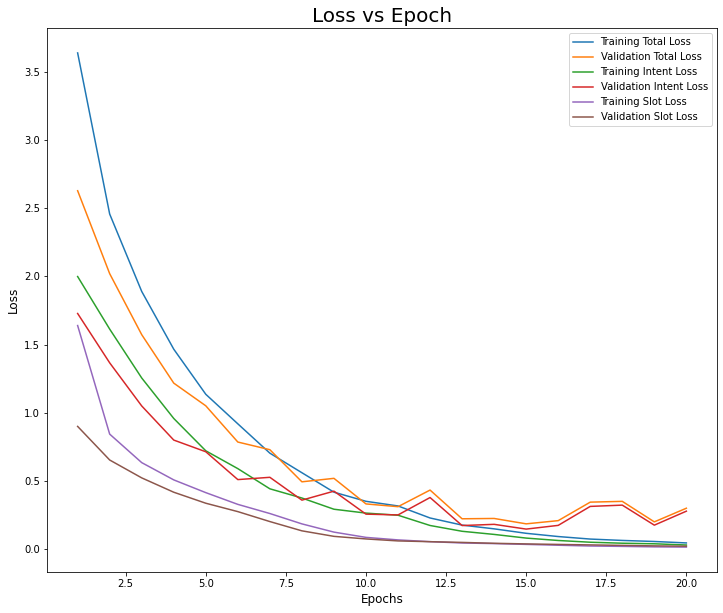

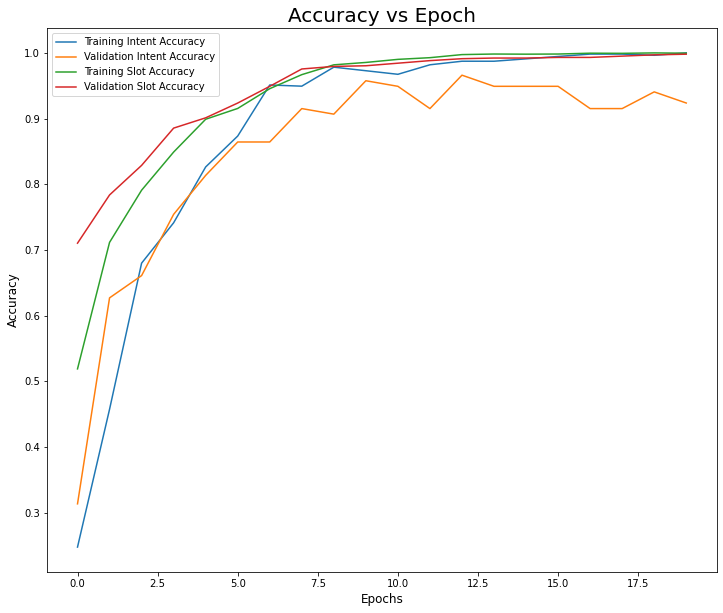

In [47]:
import matplotlib.pyplot as plt
x = np.arange(EPOCH) + 1

train_total_loss = hist['train_total_loss']
train_intent_loss = hist['train_intent_loss']
train_slot_loss = hist['train_slot_loss']
train_intent_acc = hist['train_intent_acc']
train_slot_acc = hist['train_slot_acc']

val_total_loss = hist['val_total_loss']
val_intent_loss = hist['val_intent_loss']
val_slot_loss = hist['val_slot_loss']
val_intent_acc = hist['val_intent_acc']
val_slot_acc = hist['val_slot_acc']

plt.figure(figsize=(12,10))
plt.plot(x, train_total_loss)
plt.plot(x, val_total_loss)
plt.plot(x, train_intent_loss)
plt.plot(x, val_intent_loss)
plt.plot(x, train_slot_loss)
plt.plot(x, val_slot_loss)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epoch', fontsize=20)
plt.legend(['Training Total Loss', 'Validation Total Loss', 'Training Intent Loss', 'Validation Intent Loss', 'Training Slot Loss', 'Validation Slot Loss'])
plt.show()

plt.figure(figsize=(12,10))
plt.plot(train_intent_acc)
plt.plot(val_intent_acc)
plt.plot(train_slot_acc)
plt.plot(val_slot_acc)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Epoch', fontsize=20)
plt.legend(['Training Intent Accuracy', 'Validation Intent Accuracy', 'Training Slot Accuracy', 'Validation Slot Accuracy'])
plt.show()

## Save Model Setup

In [48]:
model_setup = {'BATCH_SIZE': BATCH_SIZE,
               'EPOCH': EPOCH,
               'OPTIMIZER': str(OPTIM),
               'LEARNING_RATE:': LR,
               'TRAINED_MODEL_STATE_FILE': SAVE_FILE_NAME,
               'TRAINING_HISTORY': hist
              }

setup_file = open(MODEL_SETUP_PATH, 'wb')
pickle.dump(model_setup, setup_file, protocol=pickle.HIGHEST_PROTOCOL)
setup_file.close()

# 4. Evaluation

## Predict Function

In [30]:
# Functions to Extract Slot Values
def extract_slot_values(input_text, bio_labels, offset_mapping, slot_B_index, slot_I_index):
    slot_value = []
    
    start_char = None
    
    for i in range(len(bio_labels)):
        if bio_labels[i] == slot_B_index:
            if i == len(bio_labels)-1:
                slot_value.append(input_text[offset_mapping[i][0]:offset_mapping[i][1]])
            elif bio_labels[i+1] != slot_I_index:
                slot_value.append(input_text[offset_mapping[i][0]:offset_mapping[i][1]])
            else:
                start_char = offset_mapping[i][0]
        if bio_labels[i] == slot_I_index:
            if i == len(bio_labels)-1:
                end_char = offset_mapping[i][1]
                slot_value.append(input_text[start_char : end_char])
                start_char = None
            elif bio_labels[i+1] != slot_I_index:
                end_char = offset_mapping[i][1]
                slot_value.append(input_text[start_char : end_char])
                start_char = None
        
    return slot_value

In [31]:
# Generate Predictions

def predict_intent_slot(test_loader, model, idx_to_intent, idx_to_bio):
    
    start_time = time.time()
    
    # Generate Predictions
    input_text = []
    
    actual_encoded_intent = []
    actual_encoded_bio = []
    actual_bio = []
    actual_intent = []
    actual_title = []
    actual_genre = []
    actual_actor = []
    actual_director = []
    
    pred_encoded_intent = []
    pred_encoded_bio = []
    pred_bio = []
    pred_intent = []
    pred_title = []
    pred_genre = []
    pred_actor = []
    pred_director = []
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for input_ids, attention_mask, intent, slot, slot_offset_mapping, original_text in test_loader:
            # Send to GPU
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            # Get Predictions
            intent_logits, slot_logits = model(input_ids, attention_mask)
            intent_pred = intent_logits.argmax(dim=-1)
            
            # Append Text Results
            input_text.extend(original_text)
            
            # Append Intent Results
            actual_encoded_intent.extend(intent.detach().cpu().numpy())
            actual_intent.extend([idx_to_intent[x] for x in intent.detach().cpu().tolist()])
            
            pred_encoded_intent.extend(intent_pred.detach().cpu().numpy())
            pred_intent.extend([idx_to_intent[x] for x in intent_pred.detach().cpu().tolist()])
            
            # Append BIO & Slots Results
            for i in range(slot.size()[0]):
                sample_active_slot_mask = slot[i] != -100
                sample_active_actual_slot = slot[i][sample_active_slot_mask].detach().cpu().tolist()
                sample_active_pred_slot = slot_logits[i].argmax(dim=-1)[sample_active_slot_mask].detach().cpu().tolist()
                
                sample_text = original_text[i]
                sample_offset_mapping = slot_offset_mapping[i][sample_active_slot_mask, :]
                
                sample_actual_bio = [idx_to_bio[x] for x in sample_active_actual_slot]
                sample_actual_actor = extract_slot_values(sample_text, sample_active_actual_slot, sample_offset_mapping, 0, 4)
                sample_actual_director = extract_slot_values(sample_text, sample_active_actual_slot, sample_offset_mapping, 1, 5)
                sample_actual_genre = extract_slot_values(sample_text, sample_active_actual_slot, sample_offset_mapping, 2, 6)
                sample_actual_title = extract_slot_values(sample_text, sample_active_actual_slot, sample_offset_mapping, 3, 7)
                
                sample_pred_bio = [idx_to_bio[x] for x in sample_active_pred_slot]
                sample_pred_actor = extract_slot_values(sample_text, sample_active_pred_slot, sample_offset_mapping, 0, 4)
                sample_pred_director = extract_slot_values(sample_text, sample_active_pred_slot, sample_offset_mapping, 1, 5)
                sample_pred_genre = extract_slot_values(sample_text, sample_active_pred_slot, sample_offset_mapping, 2, 6)
                sample_pred_title = extract_slot_values(sample_text, sample_active_pred_slot, sample_offset_mapping, 3, 7)
                
                actual_encoded_bio.append(', '.join([str(int(x)) for x in sample_active_actual_slot]))
                actual_bio.append(', '.join(sample_actual_bio))
                actual_actor.append(' | '.join(sample_actual_actor))
                actual_director.append(' | '.join(sample_actual_director))
                actual_genre.append(' | '.join(sample_actual_genre))
                actual_title.append(' | '.join(sample_actual_title))
                
                pred_encoded_bio.append(', '.join([str(int(x)) for x in sample_active_pred_slot]))
                pred_bio.append(', '.join(sample_pred_bio))
                pred_actor.append(' | '.join(sample_pred_actor))
                pred_director.append(' | '.join(sample_pred_director))
                pred_genre.append(' | '.join(sample_pred_genre))
                pred_title.append(' | '.join(sample_pred_title))
                
    result_actual = {'Encoded_Intent': actual_encoded_intent,
                     'Intent': actual_intent,
                     'Encoded_BIO': actual_encoded_bio,
                     'BIO': actual_bio,
                     'Slot_Actor': actual_actor,
                     'Slot_Director': actual_director,
                     'Slot_Genre': actual_genre,
                     'Slot_Title': actual_title
                    }
    
    result_pred = {'Encoded_Intent': pred_encoded_intent,
                   'Intent': pred_intent,
                   'Encoded_BIO': pred_encoded_bio,
                   'BIO': pred_bio,
                   'Slot_Actor': pred_actor,
                   'Slot_Director': pred_director,
                   'Slot_Genre': pred_genre,
                   'Slot_Title': pred_title
                  }
    
    df = pd.DataFrame(np.array([input_text, actual_encoded_intent, actual_intent, pred_encoded_intent, pred_intent, actual_encoded_bio, actual_bio, pred_encoded_bio, pred_bio, \
                                actual_actor, pred_actor, actual_director, pred_director, actual_genre, pred_genre, actual_title, pred_title]).T, \
                      columns=['Original_Text', 'GT_Encoded_Intent', 'GT_Intent', 'PRED_Encoded_Intent', 'PRED_Intent', 'GT_Encoded_BIO', 'GT_BIO', 'PRED_Encoded_BIO', 'PRED_BIO', \
                               'GT_Actor', 'PRED_Actor', 'GT_Director', 'PRED_Director', 'GT_Genre', 'PRED_Genre', 'GT_Title', 'PRED_Title'])
    result = {'Original_Text': input_text, 'Ground_Truth': result_actual, 'Predictions': result_pred}
            
    return result, df
    
    

## Generate Results on Test Dataset

In [33]:
# Load_Model

MODEL_NAME = 'BERT_Intent_Slot'
EVAL_MODEL_LOAD_PATH = CALLBACK_PATH
eval_model = BERT_Joint_Intent_Slot(NUM_INTENT_LABELS, NUM_SLOT_LABELS)

load_dict = torch.load(EVAL_MODEL_LOAD_PATH)
eval_model.load_state_dict(load_dict)

# Run on Test dataset
result_dict, result_df = predict_intent_slot(test_loader, eval_model, idx_to_intent, idx_to_bio)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
result_df

,Original_Text,GT_Encoded_Intent,GT_Intent,PRED_Encoded_Intent,PRED_Intent,GT_Encoded_BIO,GT_BIO,PRED_Encoded_BIO,PRED_BIO,GT_Actor,PRED_Actor,GT_Director,PRED_Director,GT_Genre,PRED_Genre,GT_Title,PRED_Title
0,family movies directed by M. Night Shyamalan a...,2,INFORM,2,INFORM,"2, 8, 8, 8, 1, 5, 5, 5, 5, 5, 8, 8, 0, 4, 4","B-genre, O, O, O, B-director, I-director, I-di...","2, 8, 8, 8, 1, 5, 5, 5, 5, 5, 8, 8, 0, 4, 4","B-genre, O, O, O, B-director, I-director, I-di...",Bonnie Bedelia,Bonnie Bedelia,M. Night Shyamalan,M. Night Shyamalan,family,family,,
1,What is the overall feedback of The Hobbit,4,INFORM_INTENT_MOVIE_SENTIMENT,4,INFORM_INTENT_MOVIE_SENTIMENT,"8, 8, 8, 8, 8, 8, 3, 7, 7, 7","O, O, O, O, O, O, B-title, I-title, I-title, I...","8, 8, 8, 8, 8, 8, 8, 7, 7, 7","O, O, O, O, O, O, O, I-title, I-title, I-title",,,,,,,The Hobbit,What is the overall feedback of The Hobbit
2,Can you show me some films starring María Marull,3,INFORM_INTENT_MOVIE_RECOMMENDATION,3,INFORM_INTENT_MOVIE_RECOMMENDATION,"8, 8, 8, 8, 8, 8, 8, 0, 4, 4","O, O, O, O, O, O, O, B-actor, I-actor, I-actor","8, 8, 8, 8, 8, 8, 8, 0, 4, 4","O, O, O, O, O, O, O, B-actor, I-actor, I-actor",María Marull,María Marull,,,,,,
3,Suggest me some drama films by director Giusep...,3,INFORM_INTENT_MOVIE_RECOMMENDATION,3,INFORM_INTENT_MOVIE_RECOMMENDATION,"8, 8, 8, 2, 8, 8, 8, 1, 5, 5, 5, 8, 0, 4, 4, 4, 4","O, O, O, B-genre, O, O, O, B-director, I-direc...","8, 8, 8, 2, 8, 8, 8, 1, 5, 5, 5, 8, 0, 4, 4, 4, 4","O, O, O, B-genre, O, O, O, B-director, I-direc...",Robert Downey Jr.,Robert Downey Jr.,Giuseppe Tornatore,Giuseppe Tornatore,drama,drama,,
4,Can you search for the public sentiment of a film,4,INFORM_INTENT_MOVIE_SENTIMENT,4,INFORM_INTENT_MOVIE_SENTIMENT,"8, 8, 8, 8, 8, 8, 8, 8, 8, 8","O, O, O, O, O, O, O, O, O, O","8, 8, 8, 8, 8, 8, 8, 8, 8, 8","O, O, O, O, O, O, O, O, O, O",,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,that's all for now,0,CLOSING,0,CLOSING,"8, 8, 8, 8, 8, 8","O, O, O, O, O, O","8, 8, 8, 8, 8, 8","O, O, O, O, O, O",,,,,,,,
115,Show me some adventure films acted by Kevin Sp...,3,INFORM_INTENT_MOVIE_RECOMMENDATION,3,INFORM_INTENT_MOVIE_RECOMMENDATION,"8, 8, 8, 2, 8, 8, 8, 0, 4, 4","O, O, O, B-genre, O, O, O, B-actor, I-actor, I...","8, 8, 8, 2, 8, 8, 8, 0, 4, 4","O, O, O, B-genre, O, O, O, B-actor, I-actor, I...",Kevin Spacey,Kevin Spacey,,,adventure,adventure,,
116,The name of the film is The Battle of Algiers,2,INFORM,2,INFORM,"8, 8, 8, 8, 8, 8, 3, 7, 7, 7","O, O, O, O, O, O, B-title, I-title, I-title, I...","8, 8, 8, 8, 8, 8, 3, 7, 7, 7","O, O, O, O, O, O, B-title, I-title, I-title, I...",,,,,,,The Battle of Algiers,The Battle of Algiers
117,Looking for suggestions on western movies acte...,3,INFORM_INTENT_MOVIE_RECOMMENDATION,3,INFORM_INTENT_MOVIE_RECOMMENDATION,"8, 8, 8, 8, 2, 8, 8, 8, 0, 4","O, O, O, O, B-genre, O, O, O, B-actor, I-actor","8, 8, 8, 8, 2, 8, 8, 8, 0, 4","O, O, O, O, B-genre, O, O, O, B-actor, I-actor",Hugo Weaving,Hugo Weaving,,,western,western,,


## Save Generated Results

In [54]:
result_savepath = os.path.join(basedir, 'eval_result\\' + MODEL_NAME + '_eval.csv')

result_df.to_csv(result_savepath, encoding="utf-8")

## Evaluation

In [67]:
# Intent
intent_labels = [idx_to_intent[x] for x in range(len(idx_to_intent.keys()))]
eval_actual_intent = result_df['GT_Intent']
eval_pred_intent = result_df['PRED_Intent']
print(classification_report(eval_actual_intent, eval_pred_intent, target_names=intent_labels))

                                    precision    recall  f1-score   support

                           CLOSING       0.86      1.00      0.92         6
                           CONFIRM       0.83      0.83      0.83         6
                            INFORM       1.00      1.00      1.00        38
INFORM_INTENT_MOVIE_RECOMMENDATION       1.00      1.00      1.00        38
     INFORM_INTENT_MOVIE_SENTIMENT       1.00      1.00      1.00        12
                            NEGATE       1.00      0.83      0.91         6
                               OOS       1.00      1.00      1.00         7
                         THANK_YOU       1.00      1.00      1.00         6

                          accuracy                           0.98       119
                         macro avg       0.96      0.96      0.96       119
                      weighted avg       0.98      0.98      0.98       119



In [76]:
# BIO Tags
bio_labels = [idx_to_bio[x] for x in range(len(idx_to_bio.keys()))]
eval_actual_bio = []
eval_pred_bio = []
for i in range(len(result_df)):
    sample_gt_bio = result_df['GT_Encoded_BIO'].to_list()[i].split(', ')
    sample_pred_bio = result_df['PRED_Encoded_BIO'].to_list()[i].split(', ')
    for j in range(len(sample_gt_bio)):
        eval_actual_bio.append(int(sample_gt_bio[j]))
    for j in range(len(sample_pred_bio)):
        eval_pred_bio.append(int(sample_pred_bio[j]))

print(classification_report(eval_actual_bio, eval_pred_bio, target_names=bio_labels))

              precision    recall  f1-score   support

     B-actor       1.00      1.00      1.00        41
  B-director       1.00      1.00      1.00        34
     B-genre       1.00      0.97      0.99        36
     B-title       0.89      0.89      0.89         9
     I-actor       1.00      1.00      1.00        97
  I-director       1.00      1.00      1.00        83
     I-genre       1.00      1.00      1.00        12
     I-title       1.00      0.95      0.97        20
           O       1.00      1.00      1.00       716

    accuracy                           1.00      1048
   macro avg       0.99      0.98      0.98      1048
weighted avg       1.00      1.00      1.00      1048



In [80]:
check_mask = result_df['GT_Encoded_BIO'] == result_df['PRED_Encoded_BIO']

In [82]:
result_df[check_mask==False]

,Original_Text,GT_Encoded_Intent,GT_Intent,PRED_Encoded_Intent,PRED_Intent,GT_Encoded_BIO,GT_BIO,PRED_Encoded_BIO,PRED_BIO,GT_Actor,PRED_Actor,GT_Director,PRED_Director,GT_Genre,PRED_Genre,GT_Title,PRED_Title
1,What is the overall feedback of The Hobbit,4,INFORM_INTENT_MOVIE_SENTIMENT,4,INFORM_INTENT_MOVIE_SENTIMENT,"8, 8, 8, 8, 8, 8, 3, 7, 7, 7","O, O, O, O, O, O, B-title, I-title, I-title, I...","8, 8, 8, 8, 8, 8, 8, 7, 7, 7","O, O, O, O, O, O, O, I-title, I-title, I-title",,,,,,,The Hobbit,What is the overall feedback of The Hobbit
18,Looking for musical genre,2,INFORM,2,INFORM,"8, 8, 2, 8","O, O, B-genre, O","8, 8, 8, 8","O, O, O, O",,,,,musical,,,
61,Looking at the film Full Metal Jacket,2,INFORM,2,INFORM,"8, 8, 8, 8, 3, 7, 7","O, O, O, O, B-title, I-title, I-title","8, 8, 8, 8, 3, 3, 7","O, O, O, O, B-title, B-title, I-title",,,,,,,Full Metal Jacket,Full | Metal Jacket


In [85]:
try_text = 'give me some movie recommendations'
tokenizer(try_text, )

{'input_ids': [101, 2507, 2033, 2070, 3185, 11433, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

# 5. Inference Function

In [1]:
len([])

0

In [35]:
# Functions to Extract Slot Values
def extract_slot_values(input_text, bio_labels, offset_mapping, slot_B_index, slot_I_index):
    slot_value = []
    
    start_char = None
    
    for i in range(len(bio_labels)):
        if bio_labels[i] == slot_B_index:
            if i == len(bio_labels)-1:
                slot_value.append(input_text[offset_mapping[i][0]:offset_mapping[i][1]])
            elif bio_labels[i+1] != slot_I_index:
                slot_value.append(input_text[offset_mapping[i][0]:offset_mapping[i][1]])
            else:
                start_char = offset_mapping[i][0]
        if bio_labels[i] == slot_I_index:
            if i == len(bio_labels)-1:
                end_char = offset_mapping[i][1]
                slot_value.append(input_text[start_char : end_char])
                start_char = None
            elif bio_labels[i+1] != slot_I_index:
                end_char = offset_mapping[i][1]
                slot_value.append(input_text[start_char : end_char])
                start_char = None
        
    return slot_value

In [40]:
# Inference Function
def get_intent_slot(text, tokenizer, token_length, model, idx_to_intent, idx_to_bio):
    tokenized_inputs = tokenizer(text, padding='max_length', max_length=token_length, truncation=True, return_attention_mask=True, return_offsets_mapping=True, return_tensors='pt')
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    offset_mapping = tokenized_inputs['offset_mapping']
    excluded_ids = [101, 102, 0]
    
    print(input_ids.numpy().shape)
    print(attention_mask.numpy().shape)
    print(offset_mapping.numpy().shape)
    token_mask = np.asarray([x not in excluded_ids for x in input_ids.detach().cpu().numpy()[0]])
    offset_mapping_masked = offset_mapping[0][token_mask]
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        intent_logits, slot_logits = model(input_ids, attention_mask)
        
        encoded_intent = intent_logits[0].detach().cpu().numpy().argmax(axis=-1)
        encoded_bio = slot_logits[0].detach().cpu().numpy().argmax(axis=-1)[token_mask]
    
    intent = idx_to_intent[encoded_intent]
    bio = [idx_to_bio[x] for x in encoded_bio]
    
    slot_actor = extract_slot_values(text, encoded_bio, offset_mapping_masked, 0, 4)
    slot_director = extract_slot_values(text, encoded_bio, offset_mapping_masked, 1, 5)
    slot_genre = extract_slot_values(text, encoded_bio, offset_mapping_masked, 2, 6)
    slot_title = extract_slot_values(text, encoded_bio, offset_mapping_masked, 3, 7)
    
    slot_values = {'Actor': slot_actor,
                   'Director': slot_director,
                   'Genre': slot_genre,
                   'Title': slot_title}
    
    return encoded_intent, encoded_bio, intent, bio, slot_values
    

In [37]:
# Load Tokenizer

infer_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Load_Model

MODEL_NAME = 'BERT_Intent_Slot'
EVAL_MODEL_LOAD_PATH = CALLBACK_PATH
NUM_INTENT_LABELS = len(idx_to_intent.keys())
NUM_SLOT_LABELS = len(idx_to_bio.keys())
infer_model = BERT_Joint_Intent_Slot(NUM_INTENT_LABELS, NUM_SLOT_LABELS)

load_dict = torch.load(EVAL_MODEL_LOAD_PATH)
infer_model.load_state_dict(load_dict)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

## Inference Examples

### Sample 1

In [41]:
text_input_infer = 'Show me some sci-fi movies directed by Clyde'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

(1, 32)
(1, 32)
(1, 32, 2)
Intent Predicted >>> 
3 | INFORM_INTENT_MOVIE_RECOMMENDATION
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 2 6 6 8 8 8 1]
['O', 'O', 'O', 'B-genre', 'I-genre', 'I-genre', 'O', 'O', 'O', 'B-director']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : ['Clyde']
Genre    : ['sci-fi']
Title    : []


### Sample 2

In [39]:
text_input_infer = 'Looking for some recommendations on music movies starring Kimura'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
3 | INFORM_INTENT_MOVIE_RECOMMENDATION
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 8 8 2 8 8 0 4]
['O', 'O', 'O', 'O', 'O', 'B-genre', 'O', 'O', 'B-actor', 'I-actor']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : ['Kimura']
Director : []
Genre    : ['music']
Title    : []


### Sample 3

In [205]:
text_input_infer = 'suggest me some action films by director Ida Lupino starring Chris Hemsworth'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
3 | INFORM_INTENT_MOVIE_RECOMMENDATION
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 2 8 8 8 1 5 5 5 8 0 4 4]
['O', 'O', 'O', 'B-genre', 'O', 'O', 'O', 'B-director', 'I-director', 'I-director', 'I-director', 'O', 'B-actor', 'I-actor', 'I-actor']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : ['Chris Hemsworth']
Director : ['Ida Lupino']
Genre    : ['action']
Title    : []


### Sample 4

In [208]:
text_input_infer = 'Looking for some comments on the movie named Frozen II'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
4 | INFORM_INTENT_MOVIE_SENTIMENT
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 8 8 8 8 8 3 7]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-title', 'I-title']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : []
Genre    : []
Title    : ['Frozen II']


### Sample 5

In [209]:
text_input_infer = 'western movies directed by Robert Mulligan and acted by François Cluzet'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
2 | INFORM
----------------------------------------------------------------------
BIO Predicted >>> 
[2 8 8 8 1 5 5 5 8 8 8 0 4 4 4]
['B-genre', 'O', 'O', 'O', 'B-director', 'I-director', 'I-director', 'I-director', 'O', 'O', 'O', 'B-actor', 'I-actor', 'I-actor', 'I-actor']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : ['François Cluzet']
Director : ['Robert Mulligan']
Genre    : ['western']
Title    : []


### Sample 6

In [211]:
text_input_infer = 'Director Tom Holland and actor Steven'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
2 | INFORM
----------------------------------------------------------------------
BIO Predicted >>> 
[8 1 5 8 8 0]
['O', 'B-director', 'I-director', 'O', 'O', 'B-actor']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : ['Steven']
Director : ['Tom Holland']
Genre    : []
Title    : []


### Sample 7

In [213]:
text_input_infer = 'sure thing'

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
1 | CONFIRM
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8]
['O', 'O']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : []
Genre    : []
Title    : []


### Sample 8

In [216]:
text_input_infer = "no, that's all i need, thank you so much for your help"

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
7 | THANK_YOU
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : []
Genre    : []
Title    : []


### Sample 9

In [218]:
text_input_infer = "what time is it now?"

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
6 | OOS
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 8 8 8]
['O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : []
Genre    : []
Title    : []


### Sample 10

In [222]:
text_input_infer = "how about some other movie"

infer_enc_intent, infer_enc_bio, infer_intent, infer_bio, slot_values = get_intent_slot(text_input_infer, infer_tokenizer, MAX_LENGTH, infer_model, idx_to_intent, idx_to_bio)
print('Intent Predicted >>> ')
print(f'{infer_enc_intent} |', infer_intent)
print('-' * 70)
print('BIO Predicted >>> ')
print(infer_enc_bio)
print(infer_bio)
print('-' * 70)
print('Predicted Slot Values >>>')
print('Actor    :', slot_values['Actor'])
print('Director :', slot_values['Director'])
print('Genre    :', slot_values['Genre'])
print('Title    :', slot_values['Title'])

Intent Predicted >>> 
3 | INFORM_INTENT_MOVIE_RECOMMENDATION
----------------------------------------------------------------------
BIO Predicted >>> 
[8 8 8 8 8]
['O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------
Predicted Slot Values >>>
Actor    : []
Director : []
Genre    : []
Title    : []
